✔ Dataset Loaded Successfully!
Columns: Index(['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Source Port',
       'Destination Port', 'bad_packet'],
      dtype='object')
       Time           Source Destination Protocol  Length  Source Port  \
0  0.000000  VMware_8a:60:5f   Broadcast      ARP    60.0          NaN   
1  0.081233  VMware_8a:12:84   Broadcast      ARP    60.0          NaN   
2  0.217863  VMware_8a:7e:e9   Broadcast      ARP    60.0          NaN   
3  0.419426  VMware_8a:b2:34   Broadcast      ARP    60.0          NaN   
4  0.559886  VMware_8a:4e:1c   Broadcast      ARP    60.0          NaN   

   Destination Port  bad_packet  
0               NaN         0.0  
1               NaN         0.0  
2               NaN         0.0  
3               NaN         0.0  
4               NaN         0.0  
⚠ No traffic_type column. Using last column as label.
Numeric Columns: ['Time', 'Length', 'Source Port', 'Destination Port']
Categorical Columns: ['Source', 'Destination'

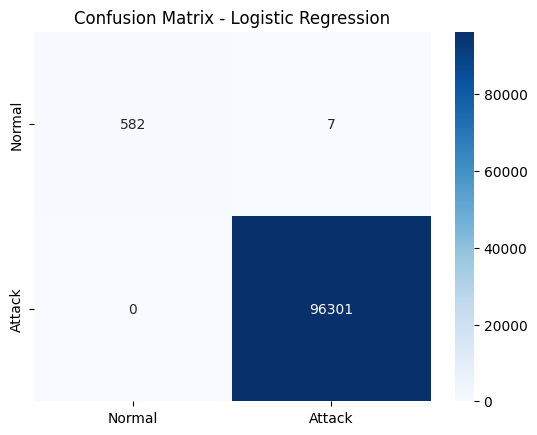


Training: Linear Regression

Results for: Linear Regression
Accuracy : 0.9999277531220973
Precision: 0.9999273165261453
Recall   : 1.0
ROC-AUC  : 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       589
           1       1.00      1.00      1.00     96301

    accuracy                           1.00     96890
   macro avg       1.00      0.99      1.00     96890
weighted avg       1.00      1.00      1.00     96890



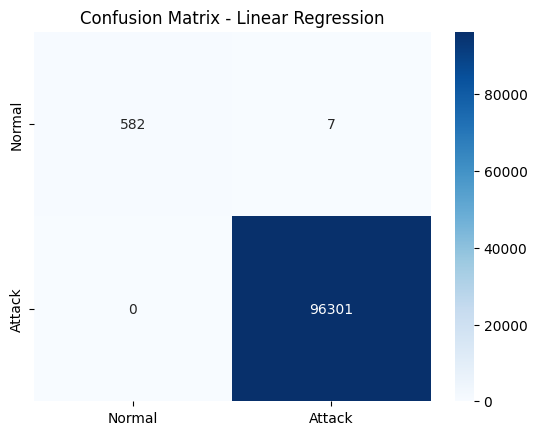


Training: Decision Tree

Results for: Decision Tree
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
ROC-AUC  : 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       589
           1       1.00      1.00      1.00     96301

    accuracy                           1.00     96890
   macro avg       1.00      1.00      1.00     96890
weighted avg       1.00      1.00      1.00     96890



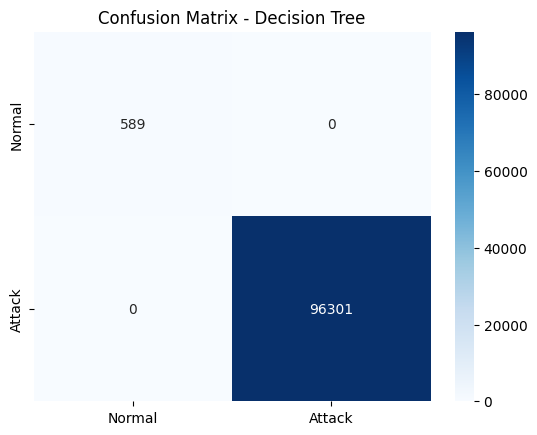


Training: Random Forest

Results for: Random Forest
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
ROC-AUC  : 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       589
           1       1.00      1.00      1.00     96301

    accuracy                           1.00     96890
   macro avg       1.00      1.00      1.00     96890
weighted avg       1.00      1.00      1.00     96890



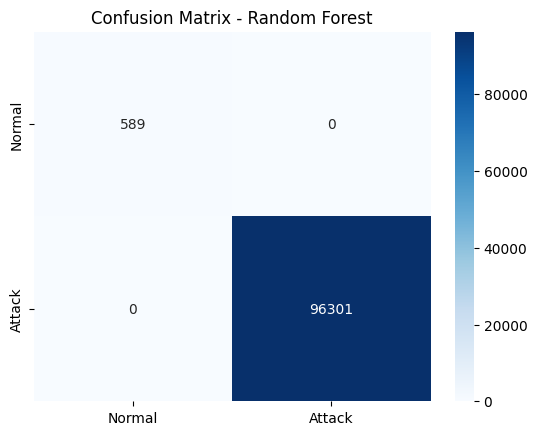

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report
)

# ============================
# 1. LOAD DATA
# ============================
df = pd.read_csv("/content/NandakumarMenonAdvait_MT_S2.csv.csv")

print("✔ Dataset Loaded Successfully!")
print("Columns:", df.columns)
print(df.head())

# ============================
# 2. FIX INF / NaN
# ============================
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(how="all", inplace=True)

# ============================
# 3. LABEL SELECTION
# ============================
if "traffic_type" in df.columns:
    df["label"] = df["traffic_type"].apply(lambda x: 0 if str(x).lower()=="normal" else 1)
    df.drop("traffic_type", axis=1, inplace=True)
else:
    df.rename(columns={df.columns[-1]: "label"}, inplace=True)
    print("⚠ No traffic_type column. Using last column as label.")

df["label"] = pd.to_numeric(df["label"], errors="coerce").fillna(0).astype(int)

X = df.drop("label", axis=1)
y = df["label"]

# ============================
# 4. COLUMN TYPES
# ============================
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)
print("Label Classes:", np.unique(y))

# ============================
# 5. PREPROCESSOR (fixed OHE)
# ============================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))   # FIXED
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# ============================
# 6. TRAIN-TEST SPLIT
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================
# 7. MODELS
# ============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200)
}

# ============================
# 8. TRAIN & EVALUATE MODELS
# ============================
for name, algo in models.items():
    print("\n========================================")
    print("Training:", name)
    print("========================================")

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("classifier", algo)
    ])

    model.fit(X_train, y_train)

    # Prediction rules
    if name == "Linear Regression":
        y_prob = model.predict(X_test)
        y_pred = (y_prob > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        if hasattr(model.named_steps["classifier"], "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_prob = y_pred

    print("\nResults for:", name)
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
    print("ROC-AUC  :", roc_auc_score(y_test, y_prob))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=["Normal", "Attack"],
                yticklabels=["Normal", "Attack"])
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
